In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.optimize import minimize
from scipy.special import erf
from scipy.stats import norm
from typing import Callable

Let $X\sim \mathcal{N}(\mu,\sigma^2)$ be a normally distributed random variable.

**Question:** How can we sample from $X$?

In this notebook we will have a look at three methods for sampling from a given distribution.

1. Inverse transform sampling
2. Rejection sampling
3. Box-Müller method

Furthermore, we will compare their efficiencies (also with `numpy.random.randn`) and visualize the results.

# Inverse transform sampling

Let $X$ be a random variable with CDF $F_X$ from which we want to generate numbers. For this, let $U \sim \text{Unif}\,[0, 1]$, then

$$
\mathbb{P}\left(F^{-1}_X(U) \leq x\right) = \mathbb{P}\left(U \leq F_X(x)\right) = F_X(x).
$$

If we have access to uniformly drawn numbers, we can generate $Y := F^{-1}_X(U)$ which has the CDF $F_X$.

In [57]:
def inverse_sampling(cdf: Callable, size: int) -> np.ndarray:
    u = np.random.rand(size)

    lb = minimize(lambda x: (cdf(x) - 0.01) ** 2, x0=0).x[0]
    ub = minimize(lambda x: (cdf(x) - 0.99) ** 2, x0=0).x[0]

    grid = np.linspace(lb, ub, 10 ** 4)
    idx = np.abs(cdf(grid).reshape(-1, 1) - u).argmin(axis=0)
    sample = grid[idx]
    return sample

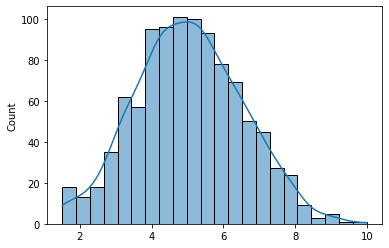

In [58]:
mu = 5
sigma = 1.5
cdf = lambda x: 1/2 * (1 + erf((x - mu) / np.sqrt(2) / sigma))

sample = inverse_sampling(cdf, size=1000)
sns.histplot(sample, kde=True);

#  Rejection sampling

In [59]:
def rejection_sampling(pdf: Callable, size: int) -> np.ndarray:
    sample = []
    while len(sample) < size:
        x = 20 * np.random.rand(size) - 10
        y = np.random.rand(size)
        idx = y < pdf(x)
        sample.extend(x[idx])
    
    return sample[:size]

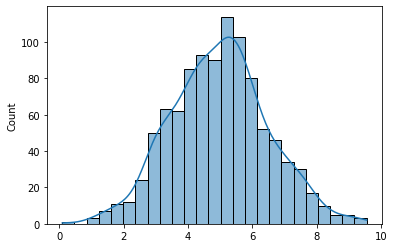

In [60]:
mu = 5
sigma = 1.5
pdf = lambda x: np.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / np.sqrt(2 * np.pi * sigma ** 2)

sample = rejection_sampling(pdf, size=1000)
sns.histplot(sample, kde=True);

# Box-Muller method

In [42]:
def box_muller_sampling(mu: float, sigma: float, size: int) -> np.ndarray:
    u = np.random.rand(size, 2)
    z = np.sqrt(-2 * np.log(u[:, 0])) * np.cos(2 * np.pi * u[:, 1])
    
    return np.sqrt(sigma) * z + mu

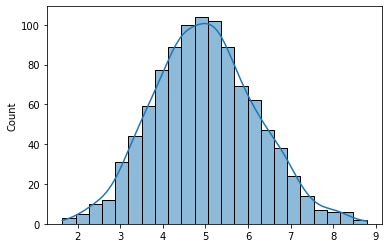

In [55]:
mu = 5
sigma = 1.5
sample = box_muller_sampling(mu, sigma, size=1000)
sns.histplot(sample, kde=True);

# Comparison

In [34]:
mu = 5
sigma = 1.5

pdf = lambda x: np.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
cdf = lambda x: 1/2 * (1 + erf((x - mu) / np.sqrt(2) / sigma))

In [29]:
%%capture
sizes = 10 ** np.arange(1, 5)

times = np.zeros((len(sizes), 4)) # four sampling methods
for i, size in enumerate(sizes):
    time_func = %timeit -o inverse_sampling(cdf, size=size);
    times[i, 0] = np.mean(time_func.timings)

    time_func = %timeit -o rejection_sampling(pdf, size=size);
    times[i, 1] = np.mean(time_func.timings)

    time_func = %timeit -o box_muller_sampling(mu, sigma, size=size);
    times[i, 2] = np.mean(time_func.timings)

    time_func = %timeit -o np.random.randn(size);
    times[i, 3] = np.mean(time_func.timings)

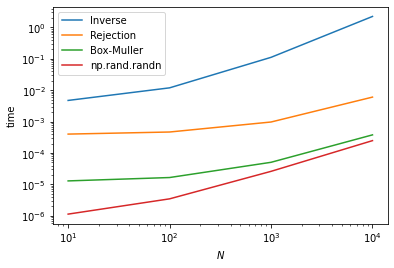

In [33]:
plt.loglog(sizes, times, label=["Inverse", "Rejection", "Box-Muller", "np.rand.randn"])
plt.xlabel(r"$N$")
plt.ylabel("time")
plt.legend();